# 🌟 BERT for Text Classification with Hugging Face Transformers

## 🔍 What is BERT?

**BERT (Bidirectional Encoder Representations from Transformers)** is a transformer-based model developed by Google for natural language processing (NLP) tasks. Unlike traditional models that process text unidirectionally, BERT is **bidirectional**, capturing context from both left and right sides of a word.

### 🎯 Key Concepts:
- **Transformer Architecture**: BERT uses the encoder part of the Transformer, with multiple layers of interconnected nodes.
- **Pre-training**: BERT is pre-trained on two tasks:
  - **Masked Language Model (MLM)**: Randomly masks words in a sentence, and the model predicts them.
  - **Next Sentence Prediction (NSP)**: Predicts if two sentences are consecutive.
- **Fine-tuning**: Adapt BERT to specific tasks (e.g., classification, question answering) using task-specific datasets.
- **Attention Mechanism**: Captures relationships between words using self-attention, allowing BERT to understand context.

## 🧠 Why BERT?
- **Bidirectional Context**: Understands word meaning based on full sentence context.
- **Transfer Learning**: Pre-trained on massive datasets, fine-tuned for specific tasks.
- **State-of-the-Art**: Excels in tasks like sentiment analysis, named entity recognition, and question answering.

## 🖼️ BERT Architecture

BERT consists of multiple **transformer encoder layers**, each with:
- **Multi-Head Self-Attention**: Captures relationships between all tokens in a sequence.
- **Feed-Forward Neural Networks**: Processes each token independently.
- **Layer Normalization and Residual Connections**: Stabilizes training.

```text
Input Tokens → Embedding (Word + Position + Segment) → [Encoder Layer] x N → [CLS] Output → Task-Specific Head
    Text         Tokenized + Embedded            Transformer Encoders       Pooled Output    Classification/Regression
```

!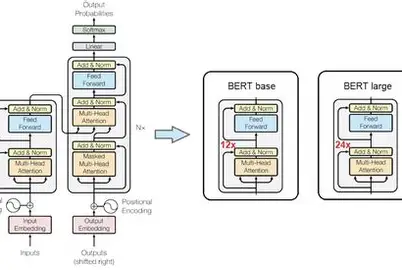

## 🔍 Derivation of Self-Attention

Self-attention computes a weighted sum of input embeddings based on their relevance. For each token:
1. Compute **Query (Q)**, **Key (K)**, and **Value (V)** vectors using linear transformations:
   \[ Q = XW_Q, \quad K = XW_K, \quad V = XW_V \]
2. Calculate attention scores:
   \[ \text{Attention Scores} = \frac{QK^T}{\sqrt{d_k}} \]
   where \(d_k\) is the dimension of the key vectors (scaling prevents large values).
3. Apply softmax to get attention weights:
   \[ \text{Attention Weights} = \text{softmax}(\frac{QK^T}{\sqrt{d_k}}) \]
4. Compute output as a weighted sum of values:
   \[ \text{Output} = \text{Attention Weights} \cdot V \]

Multi-head attention runs this process in parallel for different subspaces, concatenating results.

## 🔧 Libraries We Need

We'll use the Hugging Face Transformers library for BERT, along with datasets, tokenizers, and visualization tools.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
%matplotlib inline

## 📊 Dataset: IMDB Sentiment Analysis

We'll use the **IMDB dataset** for binary sentiment classification (positive vs. negative movie reviews). The dataset contains 50,000 reviews, which we'll subsample for demonstration.

### 🖼️ Visualizing the Data

In [ ]:
# Load IMDB dataset
dataset = load_dataset('imdb')
train_data = dataset['train'].shuffle(seed=42).select(range(1000))  # Subsample for demo
test_data = dataset['test'].shuffle(seed=42).select(range(200))

# Convert to DataFrame for visualization
df_train = pd.DataFrame({'text': train_data['text'], 'label': train_data['label']})
df_train['label'] = df_train['label'].map({0: 'Negative', 1: 'Positive'})

# Plot label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df_train)
plt.title('IMDB Dataset: Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Display sample reviews
print('Sample Reviews:')
for i in range(3):
    print(f"Review {i+1}: {df_train['text'][i][:100]}... (Label: {df_train['label'][i]})")

## 🔄 Preprocessing

- **Tokenization**: Use BERT's tokenizer to convert text into tokens, adding special tokens ([CLS], [SEP]).
- **Padding/Truncation**: Ensure all sequences have the same length.
- **Convert to Tensors**: Prepare data for PyTorch.

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Apply tokenization
train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

# Set format for PyTorch
train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Display sample tokenized data
print('Sample Tokenized Input IDs (first 10 tokens):', train_data[0]['input_ids'][:10])
print('Sample Attention Mask (first 10 tokens):', train_data[0]['attention_mask'][:10])

## 🏗️ Build the BERT Model

We'll use `BertForSequenceClassification` from Hugging Face, pre-trained on `bert-base-uncased`, and fine-tune it for binary classification.

In [ ]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True
)

# Define compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

## 🚀 Train the Model

Fine-tune BERT on the IMDB dataset for 3 epochs.

In [ ]:
# Train the model
trainer.train()

## 📈 Plot Training History

Visualize the training and validation accuracy/loss over epochs.

In [ ]:
# Extract training logs
log_history = trainer.state.log_history
train_loss = [log['loss'] for log in log_history if 'loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]
epochs = range(1, len(eval_accuracy) + 1)

# Plot loss and accuracy
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

## 🔍 Evaluate the Model

Evaluate the fine-tuned model on the test set and visualize performance metrics.

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()
print(f"Test Accuracy: {eval_results['eval_accuracy']:.2f}")

# Get predictions
predictions = trainer.predict(test_data)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = test_data['label']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

## 🖼️ Visualize Attention Weights

Visualize the attention weights for a sample input to understand how BERT focuses on different tokens.

In [ ]:
from transformers import pipeline

# Create a pipeline for text classification
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Sample text for attention visualization
sample_text = test_data['text'][0]
sample_label = 'Positive' if test_data['label'][0] == 1 else 'Negative'

# Tokenize and get attention weights
inputs = tokenizer(sample_text, return_tensors='pt', truncation=True, max_length=128)
model.eval()
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions[-1][0, 0].cpu().numpy()  # Last layer, first head

# Plot attention weights
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
plt.figure(figsize=(10, 8))
sns.heatmap(attentions[:10, :10], xticklabels=tokens[:10], yticklabels=tokens[:10], cmap='viridis')
plt.title(f'Attention Weights for Sample Review (Label: {sample_label})')
plt.xlabel('Tokens')
plt.ylabel('Tokens')
plt.show()

# Predict sentiment
result = classifier(sample_text[:512])[0]
print(f'Sample Review: {sample_text[:100]}...')
print(f'Predicted Sentiment: {result["label"]} (Score: {result["score"]:.2f})')

## 🧠 What Did BERT Learn?

- BERT learned **contextual representations** of words by considering the entire input sequence.
- The **self-attention mechanism** allowed BERT to focus on relevant words for sentiment prediction.
- Fine-tuning adapted BERT's pre-trained knowledge to the IMDB sentiment classification task.

## 📌 Key Takeaways
- BERT is a **powerful transformer model** for NLP due to its bidirectional context and pre-training.
- Fine-tuning BERT is straightforward with Hugging Face's Transformers library.
- Visualizing attention weights provides insights into how BERT processes text.
- BERT excels in tasks requiring **contextual understanding**, like sentiment analysis.

## ✅ Next Steps
Experiment with:
- Different BERT variants (e.g., `bert-large-uncased`, `distilbert-base-uncased`).
- Adjusting hyperparameters (epochs, batch size, learning rate).
- Using a larger dataset or different NLP tasks (e.g., question answering, named entity recognition).
- Exploring data augmentation techniques for text data.

Try these modifications to see how they impact performance!